# Mask Detection in Images

In [2]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import IPython

## Set the locations for the images, face detection dependencies and mask detection model

In [10]:
args = {}
args["image"] = "examples/example_02.jpg"
args["face"] = "face_detector"
args["model"] = "mask_detector.model"
args["confidence"] = 0.5

## Load the prototxt file and weights required by the face detector caffemodel

In [11]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


## Load the face mask detection model

In [12]:
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

[INFO] loading face mask detector model...


## Check the raw input image

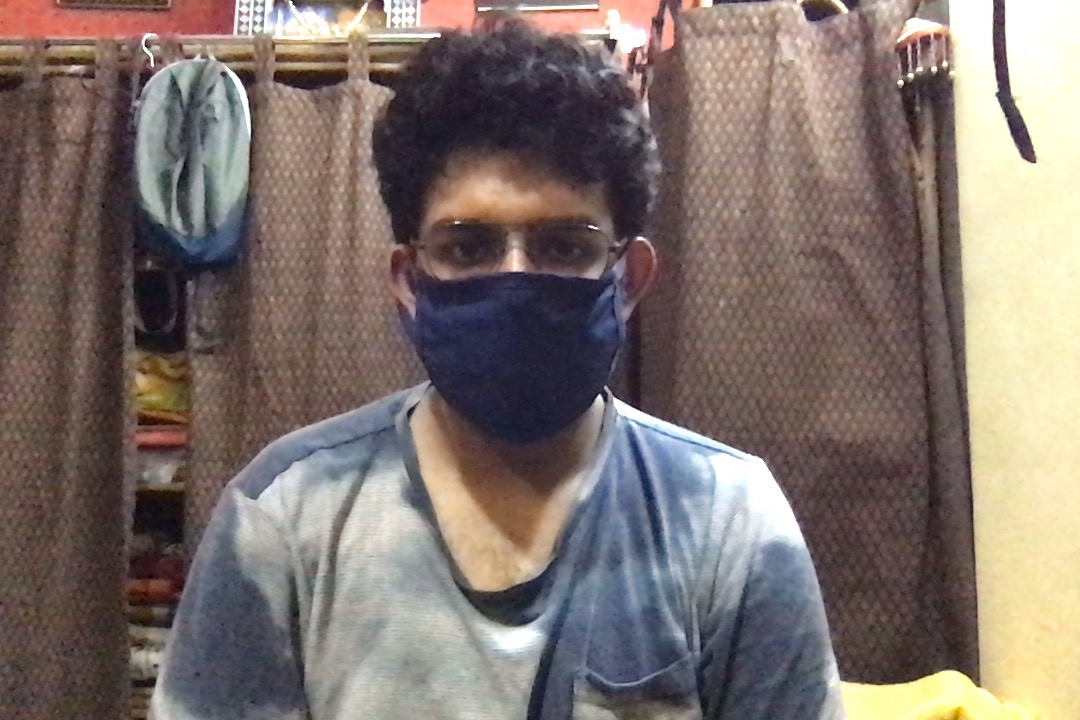

In [13]:
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]
IPython.display.Image(args["image"])

## Detect the face positions in the image

In [14]:
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


## For every detected face, predict the presence of a mask 

In [15]:
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2]

	if confidence > args["confidence"]:
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		(mask, withoutMask) = model.predict(face)[0]

		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

(1, 1, 200, 7)


## Check the final output image

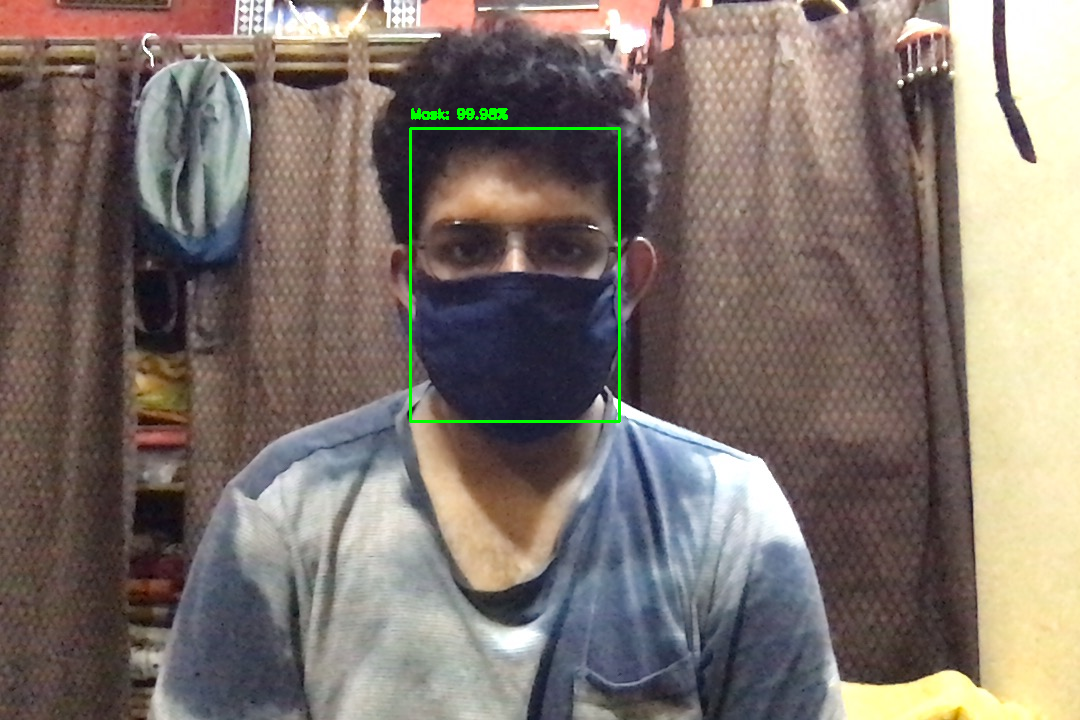

In [16]:
cv2.imwrite("output.jpg",image)
IPython.display.Image(".outputs/images/output.jpg")